# Project: Segmentation of space objects

## 1. Problem Statmenet

You are a CV specialist at a startup, tasked with building a model to predict the trajectory of active space objects to avoid collisions with space debris. Your task is to segment images of artificial satellites and space stations, achieving an mIoU metric value of >70% on the validation set.

In the training dataset each spacecraft is divided into a maximum of three parts, including the body, solar panel and antenna, marked, respectively, with three colors - green, red and blue.

## 2. Import Libraries and Define Constants

In [1]:
import albumentations as A
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split

is_debug_mode = False
print('Mode:', 'debug' if is_debug_mode else 'release')

img_size = 256 if is_debug_mode else 640
print('Image size: ', img_size)

num_epochs = 5 if is_debug_mode else 20
print('Num epochs:', num_epochs)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

batch_size = 4

images_dir = 'data/images/'
mask_dir = 'data/mask/'

Mode: release
Image size:  640
Num epochs: 20
Using device: mps


## 3. Loading Data

Define a custom dataset to load satelites data.

In [2]:
COLOR_TO_CLASS = {
    (0,   0,   0): 0,  # background
    (255, 0,   0): 1,  # red
    (0,   255, 0): 2,  # green
    (0,   0,   255): 3 # blue
}


def rgb_to_class(mask_np):
    h, w, _ = mask_np.shape
    class_mask = np.zeros((h, w), dtype=np.int64)

    for rgb, cls in COLOR_TO_CLASS.items():
        matches = np.all(mask_np == rgb, axis=-1)
        class_mask[matches] = cls

    return class_mask


In [3]:
class SattDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split="train", transform=None):
        self.images_filenames = os.listdir(image_dir + split) 
        self.transform = transform
        
        self.image_dir = image_dir + split
        self.mask_dir = mask_dir + split

        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )


    def __len__(self):
        return len(self.images_filenames)


    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        mask_name = image_name.replace('.png', '_mask.png')

        image = Image.open(os.path.join(self.image_dir, image_name)).convert("RGB")
        mask  = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB")
        #print('Loaded image:', image_name, 'mask:', mask_name)
        
        image_np = np.array(image)
        mask_np  = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_np = augmented["image"]
            mask_np  = augmented["mask"]

        # IMAGE → tensor
        image = TF.to_tensor(image_np)
        image = self.normalize(image)

        # MASK → class indices (NO to_tensor!)
        mask = rgb_to_class(mask_np)
        mask = torch.from_numpy(mask).long()  # [H,W]

        return image, mask

Define transformations for traning and validation; and augmentations for training.

In [4]:
train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(img_size, img_size)
], additional_targets={'mask': 'mask'})

/Users/dmitriygolubitskiy/Library/Mobile Documents/com~apple~CloudDocs/Documents/Technology/Data Science/IDE2/DataCleaningProject/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading datasets and defining data loaders.

For development and debugging I use Subsets of data to get results faster.

In [5]:
dataset_train = SattDataset(
    images_dir, 
    mask_dir, 
    transform=train_transform,
    split="train"
)
if is_debug_mode:
    dataset_train = torch.utils.data.Subset(dataset_train, range(400))

dataset_val = SattDataset(
    images_dir, 
    mask_dir, 
    transform=val_transform,
    split="val"
)
if is_debug_mode:
    dataset_val = torch.utils.data.Subset(dataset_val, range(100))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False)

In [6]:
image, mask = dataset_train[0]
image.shape, mask.shape

(torch.Size([3, 640, 640]), torch.Size([640, 640]))

Training dataset


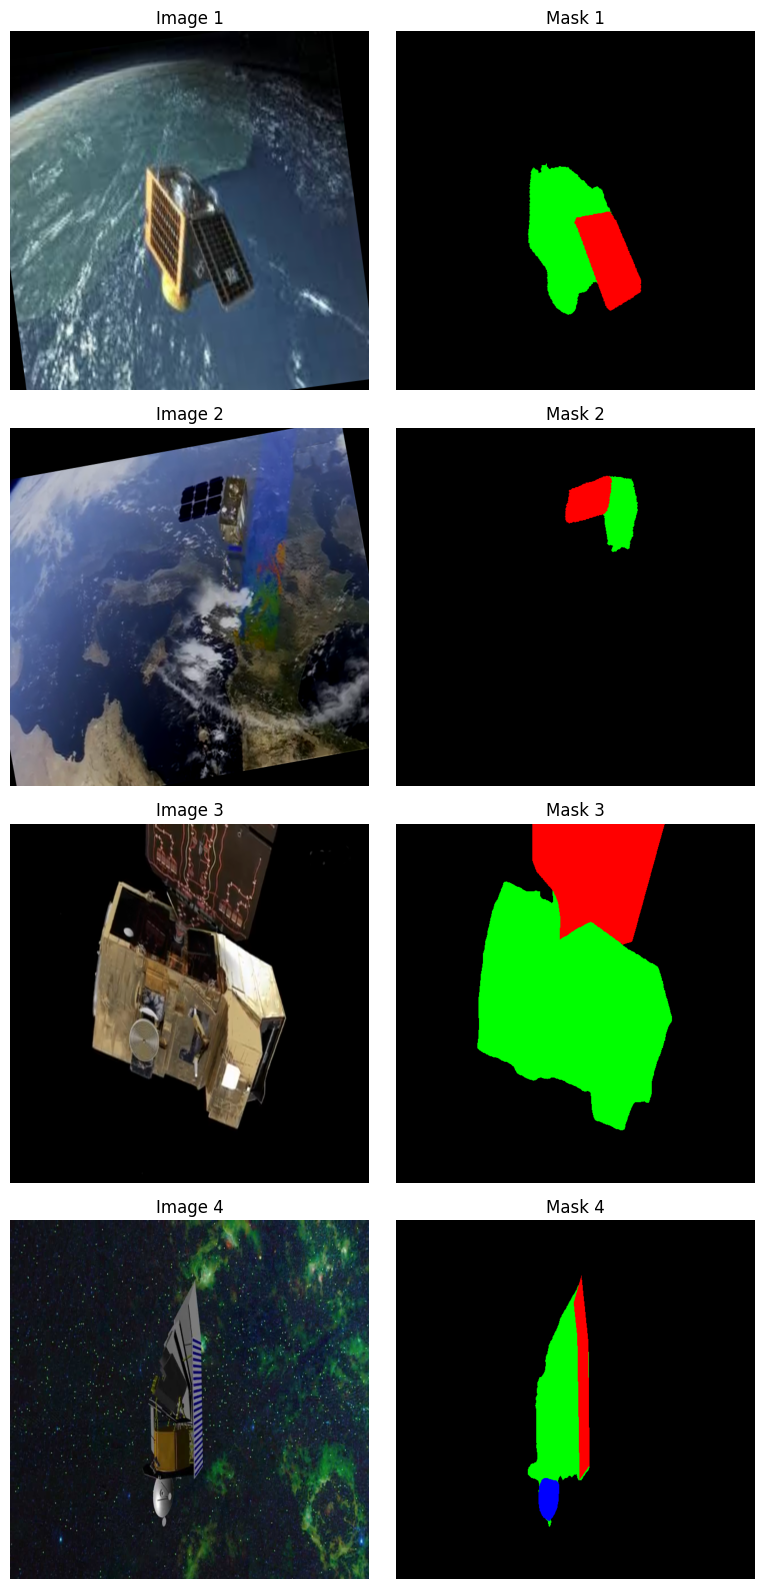

Validation dataset


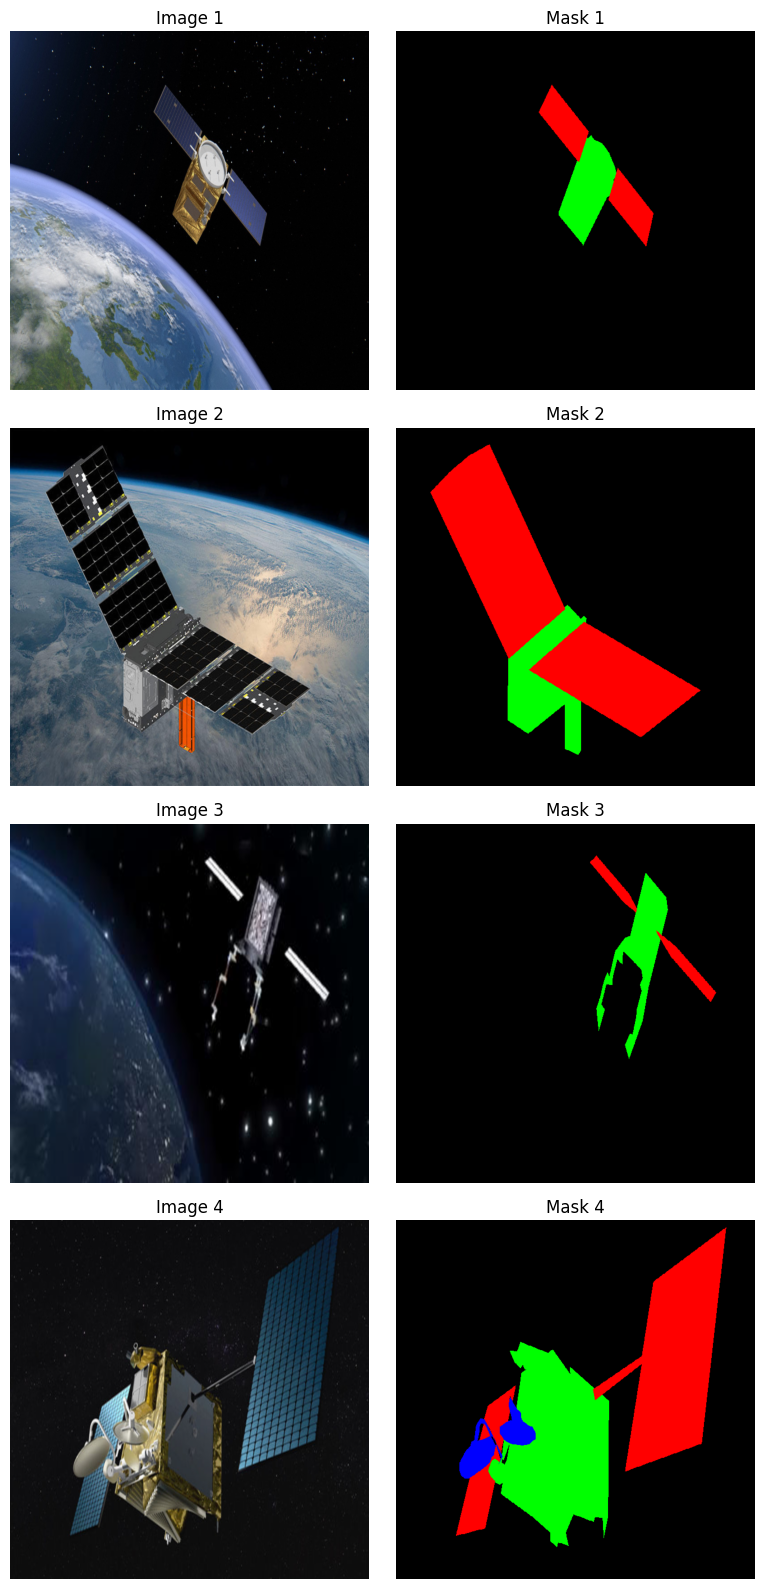

In [7]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

COLORS = np.array([
    [0,   0,   0],    # 0 background
    [255, 0,   0],    # 1 red
    [0,   255, 0],    # 2 green
    [0,   0,   255],  # 3 blue
], dtype=np.uint8)

def colorize_mask(mask):
    return COLORS[mask]

def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))

    for i in range(num_samples):
        image, mask = dataset[i]

        # Unnormalize image
        image_vis = unnormalize(image).permute(1,2,0).clamp(0,1).cpu().numpy()

        # Colorize mask
        mask_vis = colorize_mask(mask.cpu().numpy())
        
        axes[i, 0].imshow(image_vis)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_vis)
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


print("Training dataset")
plot_samples(dataset_train)
print("Validation dataset")
plot_samples(dataset_val)

## 4. Defining the Model

DeepLabV3-ResNet50 has been chosen: it is suitable for this segmentation task because it provides strong performance through multi-scale feature extraction using atrous convolutions and ASPP. The ResNet-50 backbone offers a good balance between accuracy and computational efficiency, enabling effective training even on moderately sized datasets. Overall, the model delivers reliable segmentation quality while maintaining reasonable training and inference speed.

In [8]:
model = deeplabv3_resnet50(weights=None, num_classes=4)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Defining the loss function and the optimizer.

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

IoU metric calculation.

In [10]:
def miou(outputs, targets, num_classes=4, ignore_background=True):
    preds = torch.argmax(outputs, dim=1)  # [B,H,W]

    ious = []
    classes = range(1, num_classes) if ignore_background else range(num_classes)

    for cls in classes:
        pred_c = preds == cls
        target_c = targets == cls

        intersection = (pred_c & target_c).sum().float()
        union = (pred_c | target_c).sum().float()

        if union == 0:
            continue  # ignore empty class

        ious.append(intersection / union)

    if len(ious) == 0:
        return torch.tensor(0.0, device=outputs.device)

    return torch.mean(torch.stack(ious))


## 5. Training and Validation

In [11]:
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_iou  = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou  += miou(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou  /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_iou  = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou  += miou(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train mIoU: {train_iou:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val mIoU: {val_iou:.4f}")

100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 1/20 | Train Loss: 0.2076 | Train mIoU: 0.4856 | Val Loss: 0.1328 | Val mIoU: 0.5676


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 2/20 | Train Loss: 0.1075 | Train mIoU: 0.5746 | Val Loss: 0.1097 | Val mIoU: 0.6312


100%|██████████| 150/150 [03:11<00:00,  1.28s/it]


Epoch 3/20 | Train Loss: 0.0927 | Train mIoU: 0.6014 | Val Loss: 0.0985 | Val mIoU: 0.6401


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 4/20 | Train Loss: 0.0814 | Train mIoU: 0.6332 | Val Loss: 0.0941 | Val mIoU: 0.6551


100%|██████████| 150/150 [03:29<00:00,  1.40s/it]


Epoch 5/20 | Train Loss: 0.0736 | Train mIoU: 0.6509 | Val Loss: 0.0941 | Val mIoU: 0.6687


100%|██████████| 150/150 [02:15<00:00,  1.11it/s]


Epoch 6/20 | Train Loss: 0.0665 | Train mIoU: 0.6798 | Val Loss: 0.1059 | Val mIoU: 0.5943


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 7/20 | Train Loss: 0.0645 | Train mIoU: 0.6849 | Val Loss: 0.0902 | Val mIoU: 0.6639


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 8/20 | Train Loss: 0.0597 | Train mIoU: 0.6980 | Val Loss: 0.0997 | Val mIoU: 0.6623


100%|██████████| 150/150 [03:49<00:00,  1.53s/it]


Epoch 9/20 | Train Loss: 0.0594 | Train mIoU: 0.7026 | Val Loss: 0.0841 | Val mIoU: 0.6833


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 10/20 | Train Loss: 0.0528 | Train mIoU: 0.7169 | Val Loss: 0.0810 | Val mIoU: 0.6851


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 11/20 | Train Loss: 0.0451 | Train mIoU: 0.7529 | Val Loss: 0.0895 | Val mIoU: 0.6836


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 12/20 | Train Loss: 0.0458 | Train mIoU: 0.7455 | Val Loss: 0.0831 | Val mIoU: 0.7026


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 13/20 | Train Loss: 0.0500 | Train mIoU: 0.7364 | Val Loss: 0.0995 | Val mIoU: 0.6779


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


Epoch 14/20 | Train Loss: 0.0496 | Train mIoU: 0.7510 | Val Loss: 0.0932 | Val mIoU: 0.6525


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Epoch 15/20 | Train Loss: 0.0395 | Train mIoU: 0.7708 | Val Loss: 0.0895 | Val mIoU: 0.6974


100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


Epoch 16/20 | Train Loss: 0.0401 | Train mIoU: 0.7866 | Val Loss: 0.1089 | Val mIoU: 0.6680


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


Epoch 17/20 | Train Loss: 0.0398 | Train mIoU: 0.7798 | Val Loss: 0.0882 | Val mIoU: 0.7074


100%|██████████| 150/150 [03:30<00:00,  1.40s/it]


Epoch 18/20 | Train Loss: 0.0446 | Train mIoU: 0.7658 | Val Loss: 0.0976 | Val mIoU: 0.6828


100%|██████████| 150/150 [02:17<00:00,  1.09it/s]


Epoch 19/20 | Train Loss: 0.0389 | Train mIoU: 0.7811 | Val Loss: 0.0824 | Val mIoU: 0.7030


100%|██████████| 150/150 [02:16<00:00,  1.10it/s]

Epoch 20/20 | Train Loss: 0.0364 | Train mIoU: 0.8033 | Val Loss: 0.0814 | Val mIoU: 0.7133


Trained model inference and visualization of results.

Sample 1


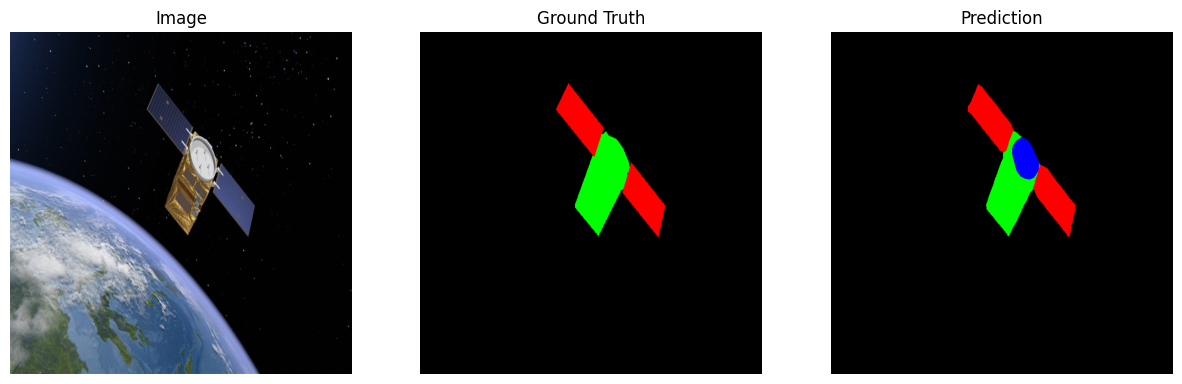

Sample 2


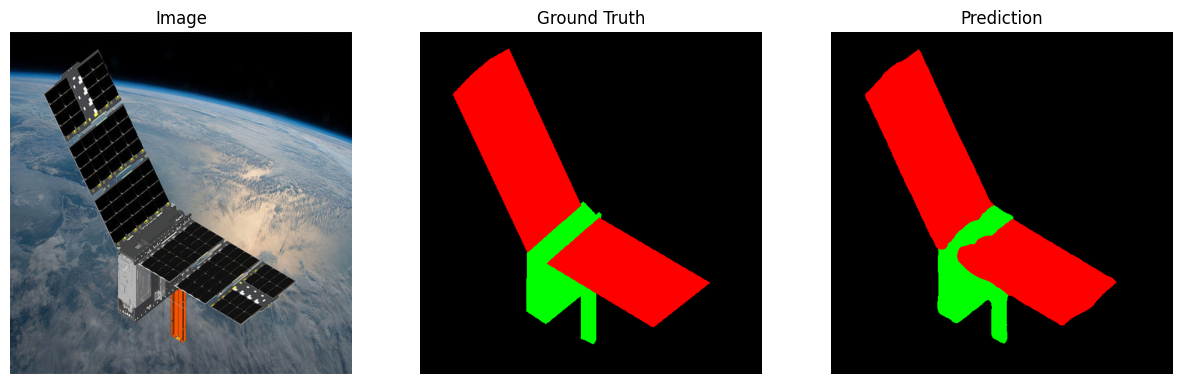

Sample 3


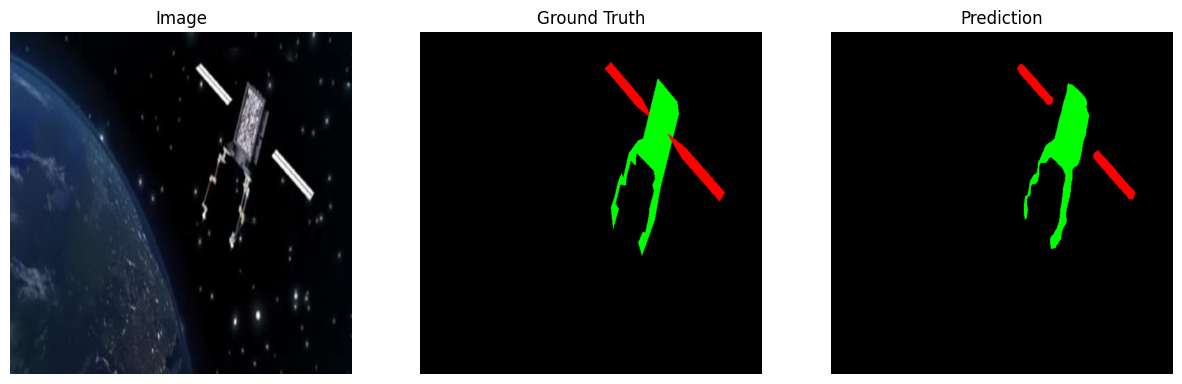

Sample 4


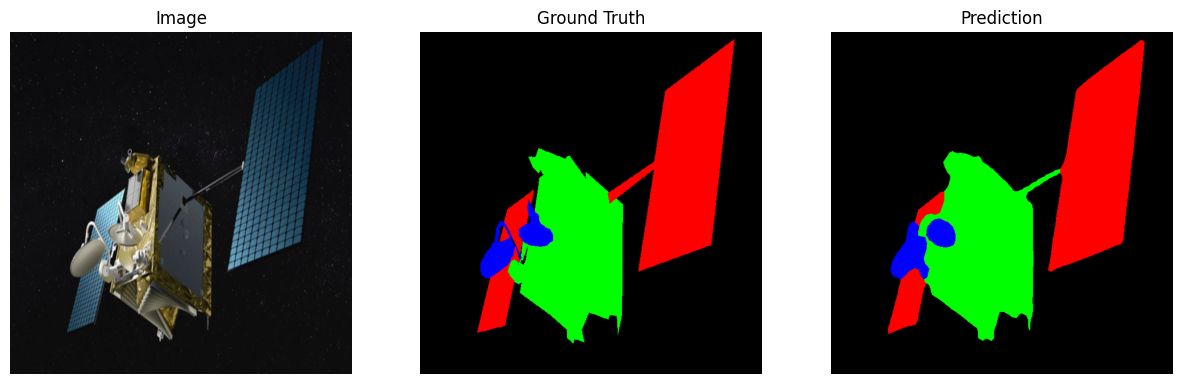

Sample 5


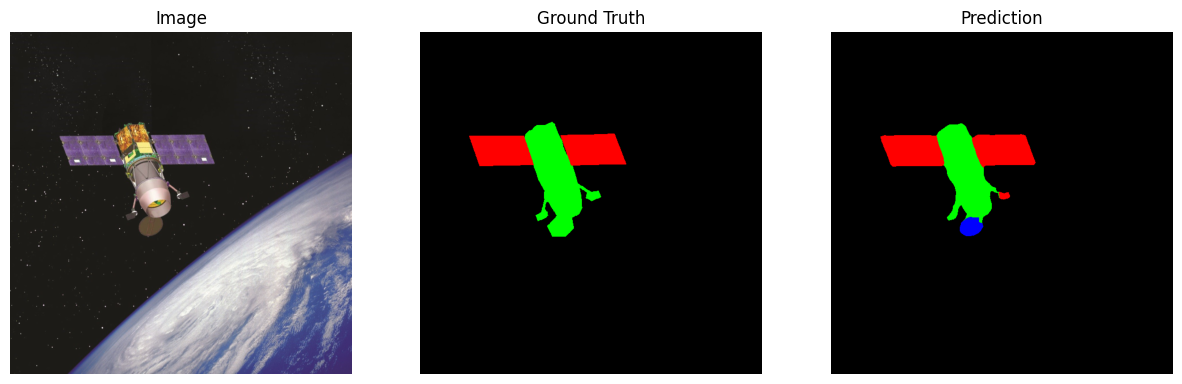

Sample 6


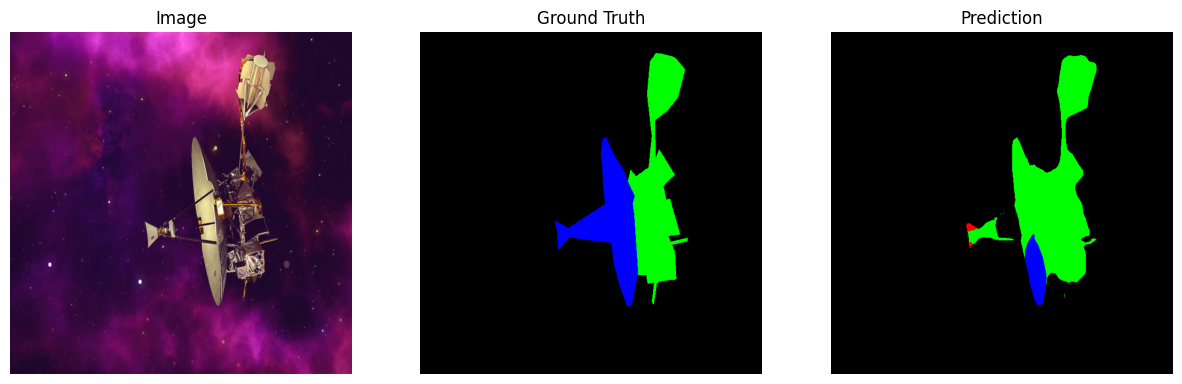

Sample 7


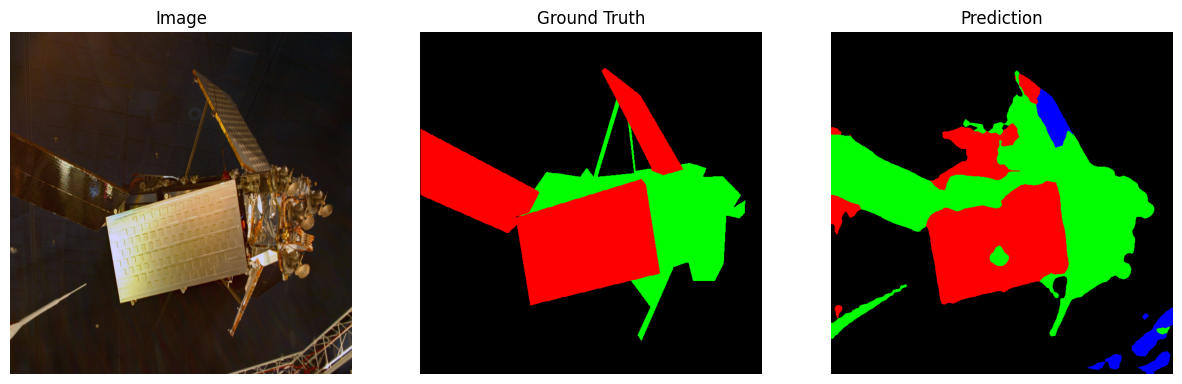

Sample 8


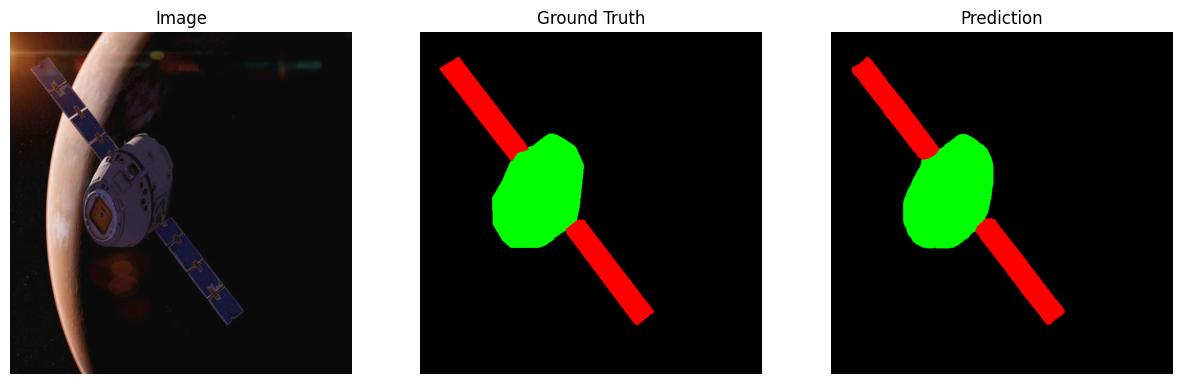

Sample 9


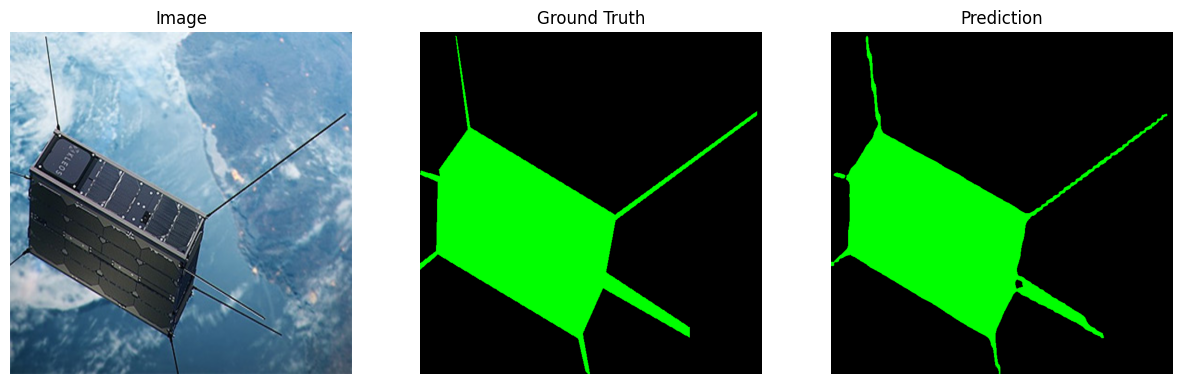

Sample 10


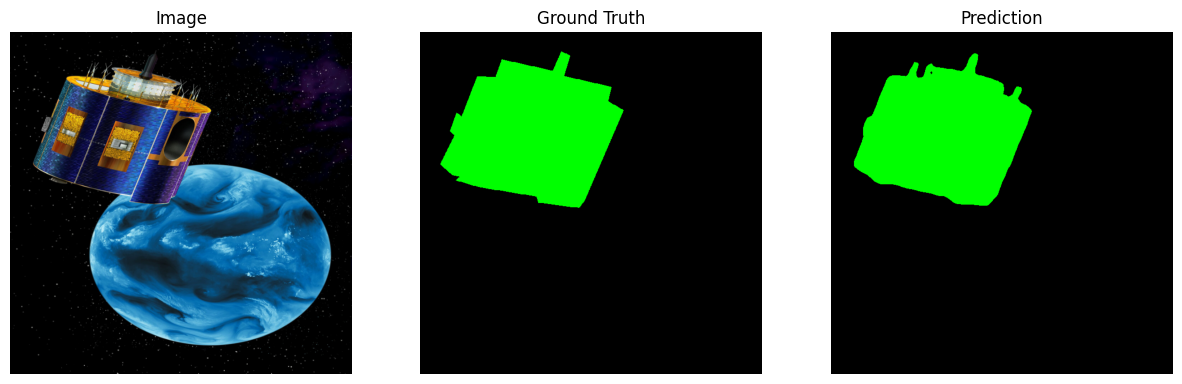

In [12]:
model.eval()

with torch.no_grad():

    for i in range(10):    
        image, mask = dataset_val[i]

        x = image.unsqueeze(0).to(device)     # [1,3,H,W]
        logits = model(x)["out"]               # [1,4,H,W]
        pred = torch.argmax(logits, dim=1)     # [1,H,W]
        pred = pred.squeeze(0).cpu()           # [H,W]
        
        image_vis = unnormalize(image).permute(1,2,0).clamp(0,1).cpu().numpy()
        gt_vis    = colorize_mask(mask.cpu().numpy())
        pred_vis  = colorize_mask(pred.numpy())

        print(f"Sample {i+1}")

        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(image_vis)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Ground Truth")
        plt.imshow(gt_vis)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(pred_vis)
        plt.axis("off")

        plt.show()


## 6. Conclusion

The trained model has achieved the mIoU value of 0.71 on the validatation dataset, which is above the target defined for this project.

Inference examples visually confirm a good level of segmentation.